In [1]:
import pickle
import pandas as pd
import numpy as np
from IPython.display import Audio
import torch
import torchaudio
from IPython.display import Audio, display
import json
import os
from pathlib import Path

In [2]:
import pickle
import pandas as pd
import numpy as np
from IPython.display import Audio
import torch
import torchaudio
from IPython.display import Audio, display
import json
import os
from pathlib import Path
# import shutil
from glob import glob



def get_df(exp_root, dir):
    exp_dir = Path(exp_root)/dir
    pkl_results_file = os.path.join(exp_dir, "measures.pickle")

    with open(pkl_results_file, "rb") as handle:
        dfme = pd.read_pickle(handle).reset_index(drop=True)
    return dfme


def get_df_storm(pkl_results_file, snr=None):
    # pkl_results_file = "/data/ephraim/datasets/known_noise/sgmse/exp_l/enhanced/storm_vbd/measures_storm.pickle"
    # pkl_results_file = "/data/ephraim/datasets/known_noise/sgmse/exp_k/enhanced/storm_TIMITChime3/measures_storm.pickle"
        # pkl_results_file = "/data/ephraim/datasets/known_noise/sgmse/exp_l/enhanced/sgmse_WSJ0Chime3/measures_storm.pickle"
    # pkl_results_file = "/data/ephraim/datasets/known_noise/sgmse/exp_k/enhanced/sgmse_TIMITChime3/measures_storm.pickle"
    with open(pkl_results_file, "rb") as handle:
        df2 = pd.read_pickle(handle)
    for i in range(len(df2["snr"])):
        df2.at[i, "snr"] = df2["snr"][i].split("_")[0]
    if snr is None:
        df_storm_ = df2.reset_index(drop=True).sort_values(by=['dir'])
    else:
        df_storm_ = df2[df2["snr"]==snr].reset_index(drop=True).sort_values(by=['dir'])
    return df_storm_


def write_results(df, name_alg,analysis_root,noises):
    print("write")
    # df.to_excel(os.path.join(analysis_root, f"{name_alg}_all.xlsx"))
    # for noisetype in noises:
    #     noise_mine  = df[df["noise_type"]==noisetype]
    #     noise_mine.to_excel(os.path.join(analysis_root, f"{name_alg}_{noisetype}.xlsx"))


def drop_rows_without_comparison(df, ours_df):
    for i in range(len(df["dir"])):
        dir_ = df["dir"][i]
        noisetype = df["noise_type"][i]
        mine_parallel = ours_df[(ours_df["dir"]==dir_) & (ours_df["noise_type"]==noisetype)]
        if len(mine_parallel)==0:
            idx = df[(df.dir==dir_)&(df.noise_type==noisetype)].index
            df = df.drop(idx)
        return df


def get_stats_df(df, alg_name, dir_=None, noise_type=None, snr_=None):
    if dir_:
        df = df[df["dir"]==dir_]
    if noise_type:
        df = df[df["noise_type"]==noise_type]
    if snr_:
        df = df[df["snr"]==snr_]
    dfstats = df.describe()[1:3]
    dfstats = dfstats.assign(alg=alg_name)
    return dfstats


def create_mine_df(exp_root,df_noisy,mine,noises,cols,names,snrs):
    for d in names: 
        dfme = get_df(exp_root,d)
        if dfme is None:
            continue
        dfme = dfme.assign(dir=d)
        cur_df_noisy = dfme[dfme["name"]=="noisy"].reset_index(drop=True)
        cur_df_noisy.loc[0,"dir"] = d
        if df_noisy is None:
            df_noisy = cur_df_noisy
        else:
            df_noisy = pd.concat([df_noisy, cur_df_noisy])
        dfme = dfme[dfme["name"] != "noisy"]
        
        dfme = dfme[dfme["stoi"]>0.5]

        for noisetype in noises :
            for c_snr in snrs:
                c_snr=str(c_snr)
                dfme_cur = dfme[dfme["snr"]==c_snr]
                cur_mine = dfme_cur[dfme_cur["noise_type"]==noisetype]
                cur_mine = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]
                if mine is None:
                    mine = cur_mine
                else:
                    mine = pd.concat([mine, cur_mine])
    mine=mine.reset_index(drop=True)
    return mine, df_noisy

# def copy_wavs(df,wavdst,algname):
#     df = df.reset_index(drop=True)
#     for i in df.index.values:
#         wavpath = df["filename"][i]
#         dir_ = df["dir"][i]
#         snr = df["snr"][i]
#         noisetype = df["noise_type"][i]
#         name = f"{dir_}_{noisetype}_snr{snr}_{algname}.wav"
#         dst = wavdst/f"{name}"
#         print("origin:", wavpath)
#         print("dst:", dst)
#         shutil.copyfile(wavpath, dst)


from audio_tools2  import *
def calc_vad(f, verbose=False):
    test_file=f
    fs,s = read_wav(test_file)
    win_len = int(fs*0.025)
    hop_len = int(fs*0.010)
    sframes = enframe(s,win_len,hop_len) # rows: frame index, cols: each frame
    if verbose:
        plot_this(compute_log_nrg(sframes))

    # percent_high_nrg is the VAD context ratio. It helps smooth the
    # output VAD decisions. Higher values are more strict.
    percent_high_nrg = 0.5

    vad = nrg_vad(sframes,percent_high_nrg)

    if verbose:
        plot_these(deframe(vad,win_len,hop_len),s)
    return deframe(vad,win_len,hop_len) 


   



In [3]:
utterance = "18"

In [4]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net6cmog2/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
5,s0.11,0.343189,0.786949,1.110655,1.083343,1.093142,1.169141,1.088812,-39.062889,-22.553306,-22.553306,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [5]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net6cmog1/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
3,noisy,0.786949,0.786949,1.083343,1.083343,1.853806,3.308367,1.893687,5.005522,5.043435,5.043435,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [6]:
df3

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
0,s1e-05,0.086115,0.786949,1.064110,1.083343,2.997567,3.267511,3.970637,-47.274750,-26.305698,-26.305698,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
1,s0.0001,0.273620,0.786949,1.047144,1.083343,2.940264,3.322698,3.788501,-51.555611,-22.702190,-22.702190,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
2,s0.001,0.166703,0.786949,1.069221,1.083343,3.282827,3.484668,4.158390,-43.995785,-23.527898,-23.527898,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
3,noisy,0.786949,0.786949,1.083343,1.083343,1.853806,3.308367,1.893687,5.005522,5.043435,5.043435,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [7]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net6cmog1/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
3,noisy,0.786949,0.786949,1.083343,1.083343,1.853806,3.308367,1.893687,5.005522,5.043435,5.043435,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [8]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net6/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
1,s0.1,0.733124,0.786949,1.465614,1.083343,2.974083,3.324561,3.908973,9.832843,11.308017,11.308017,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [9]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net6_5lr0_01/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
12,s0.28,0.187144,0.786949,1.138502,1.083343,2.761333,3.102896,3.778152,-38.752102,-19.434019,-19.434019,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [10]:
df3

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
0,s1e-05,0.228985,0.786949,1.118534,1.083343,2.987246,3.289297,3.914174,-50.944996,-21.991522,-21.991522,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
1,s0.0001,0.231283,0.786949,1.026969,1.083343,3.184759,3.443668,4.074815,-41.154289,-21.056633,-21.056633,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
2,s0.001,0.199223,0.786949,1.070898,1.083343,3.070057,3.366031,4.003375,-34.223427,-19.697213,-19.697213,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
3,s0.09,0.157390,0.786949,1.048198,1.083343,3.258740,3.473122,4.119054,-38.067223,-22.895033,-22.895033,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
4,s0.1,0.158100,0.786949,1.093990,1.083343,2.909441,3.284072,3.802767,-41.240654,-22.558835,-22.558835,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
5,s0.11,0.144825,0.786949,1.057320,1.083343,3.189626,3.459297,4.042598,-40.099327,-23.714561,-23.714561,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
6,s0.15,0.194166,0.786949,1.072657,1.083343,3.209136,3.433520,4.135110,-40.564537,-24.060288,-24.060288,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
7,s0.16,0.182536,0.786949,1.040229,1.083343,3.104461,3.342726,4.044504,-51.908321,-13.729452,-13.729452,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
8,s0.18,0.141261,0.786949,1.033892,1.083343,2.977221,3.284143,3.914127,-58.399067,-24.806555,-24.806555,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
9,s0.2,0.182102,0.786949,1.033463,1.083343,2.762694,3.406460,3.403684,-54.696125,-24.029931,-24.029931,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [11]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net3_5/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
38,s10000,0.753279,0.786949,1.476308,1.083343,3.036896,3.402443,3.893756,10.590351,11.657235,11.657235,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [12]:
df3

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
0,s1e-05,0.089993,0.786949,1.041418,1.083343,3.203787,3.416597,4.121734,-60.905643,-20.589543,-20.589543,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
1,s0.0001,0.165570,0.786949,1.040543,1.083343,3.198655,3.501181,3.974087,-73.569939,-25.695743,-25.695743,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
2,s0.001,0.112340,0.786949,1.036772,1.083343,3.163627,3.446774,4.065793,-47.086063,-25.560921,-25.560921,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
3,s0.09,0.196747,0.786949,1.033368,1.083343,3.115626,3.409770,3.999725,-40.282814,-21.373049,-21.373049,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
4,s0.1,0.071946,0.786949,1.049711,1.083343,2.935028,3.096052,4.136751,-44.763275,-23.906357,-23.906357,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
5,s0.11,0.215539,0.786949,1.057934,1.083343,3.538379,3.739502,4.207987,-56.219139,-22.236026,-22.236026,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
6,s0.15,0.260234,0.786949,1.093644,1.083343,3.320814,3.594747,4.068132,-41.291348,-19.176821,-19.176821,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
7,s0.16,0.104032,0.786949,1.035734,1.083343,3.346121,3.601955,4.128595,-48.458199,-27.152530,-27.152530,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
8,s0.18,0.216896,0.786949,1.036509,1.083343,3.290409,3.522269,4.114159,-53.835526,-25.660562,-25.660562,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
9,s0.2,0.190742,0.786949,1.061376,1.083343,3.299958,3.541549,4.120766,-60.455147,-23.706478,-23.706478,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [31]:
utterance="6"

In [32]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net3/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
8,s0.18,0.802818,0.771755,1.468682,1.044076,2.760864,3.272822,3.468462,9.365672,9.976536,9.976536,inf,6,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [33]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net3_6/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
8,s0.18,0.812078,0.771755,1.429227,1.044076,2.974764,3.49925,3.561935,9.651472,10.129444,10.129444,inf,6,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [34]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net3_6b/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
0,s0.001,0.206962,0.771755,1.429693,1.044076,3.264864,3.575685,4.030602,-44.838585,-24.759697,-24.759697,inf,6,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [35]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net3_6c/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
6,s0.15,0.779819,0.771755,1.432214,1.044076,2.61281,3.281939,3.145874,9.47636,10.183958,10.183958,inf,6,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [36]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net3_6mog2/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
8,s0.0005,0.202507,0.771755,1.071343,1.044076,2.893756,3.298458,3.663553,-46.758377,-19.089989,-19.089989,inf,6,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [37]:
df3

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
0,s1e-05,0.185715,0.771755,1.064090,1.044076,3.232180,3.448429,4.120482,-37.012943,-19.409488,-19.409488,inf,6,/data/ephraim/datasets/known_noise/undiff_exps...,5
1,s0.0001,0.234113,0.771755,1.034132,1.044076,3.308680,3.601757,4.068565,-44.639965,-22.868012,-22.868012,inf,6,/data/ephraim/datasets/known_noise/undiff_exps...,5
2,s0.001,0.223096,0.771755,1.069500,1.044076,2.987657,3.375434,3.655734,-35.087746,-23.945973,-23.945973,inf,6,/data/ephraim/datasets/known_noise/undiff_exps...,5
3,s0.09,0.369526,0.771755,1.031850,1.044076,1.087706,1.174373,1.091053,-30.738428,-21.378096,-21.378096,inf,6,/data/ephraim/datasets/known_noise/undiff_exps...,5
4,s0.1,0.350790,0.771755,1.026479,1.044076,1.097687,1.179829,1.092969,-33.262447,-21.081586,-21.081586,inf,6,/data/ephraim/datasets/known_noise/undiff_exps...,5
5,s0.11,0.347174,0.771755,1.037395,1.044076,1.093578,1.187548,1.107745,-32.214825,-22.133667,-22.133667,inf,6,/data/ephraim/datasets/known_noise/undiff_exps...,5
6,s0.15,0.312881,0.771755,1.031017,1.044076,1.076663,1.182346,1.113254,-33.795238,-22.588286,-22.588286,inf,6,/data/ephraim/datasets/known_noise/undiff_exps...,5
7,s0.16,0.242731,0.771755,1.071203,1.044076,1.076964,1.195553,1.112287,-37.753376,-22.875387,-22.875387,inf,6,/data/ephraim/datasets/known_noise/undiff_exps...,5
8,s0.0005,0.202507,0.771755,1.071343,1.044076,2.893756,3.298458,3.663553,-46.758377,-19.089989,-19.089989,inf,6,/data/ephraim/datasets/known_noise/undiff_exps...,5
9,s0.005,0.216190,0.771755,1.028272,1.044076,2.079836,3.382561,1.891583,-31.522995,-23.348286,-23.348286,inf,6,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [18]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net3_6c/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
6,s0.15,0.400544,0.786949,1.511165,1.083343,1.863149,2.42121,3.725745,-53.652733,-31.092583,-31.092583,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [19]:
df3

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
0,s1e-05,0.165434,0.786949,1.050612,1.083343,3.336415,3.562313,4.131274,-47.736526,-20.034664,-20.034664,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
1,s0.0001,0.169396,0.786949,1.049124,1.083343,2.964527,3.402927,3.812712,-67.912376,-17.971927,-17.971927,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
2,s0.001,0.157021,0.786949,1.043294,1.083343,3.307945,3.584315,4.065262,-51.628395,-20.736572,-20.736572,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
3,s0.09,0.394370,0.786949,1.028635,1.083343,1.704170,2.175228,3.475558,-66.656151,-25.381672,-25.381672,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
4,s0.1,0.383797,0.786949,1.260089,1.083343,1.647204,2.246049,3.417304,-65.140717,-18.818315,-18.818315,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
5,s0.11,0.383569,0.786949,1.066640,1.083343,1.852392,2.389462,3.518540,-58.062931,-25.022394,-25.022394,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
6,s0.15,0.400544,0.786949,1.511165,1.083343,1.863149,2.421210,3.725745,-53.652733,-31.092583,-31.092583,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
7,s0.16,0.392054,0.786949,1.033504,1.083343,1.828369,2.318711,3.627314,-54.882942,-25.856923,-25.856923,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
8,s0.18,0.389501,0.786949,1.045754,1.083343,1.918878,2.463932,3.767045,-57.227741,-24.340944,-24.340944,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
9,s0.2,0.397470,0.786949,1.065386,1.083343,2.080103,2.664556,3.846554,-54.173107,-23.195366,-23.195366,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [14]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net3_6b/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
8,s0.18,0.406646,0.786949,1.124483,1.083342,1.728914,2.328013,3.431741,-54.957245,-22.284074,-22.284074,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [15]:
df3

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
0,s1e-05,0.161103,0.786949,1.060627,1.083342,2.921011,3.529503,3.564495,-44.375721,-22.743188,-22.743188,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
1,s0.0001,0.200197,0.786949,1.082945,1.083342,2.644460,2.916169,3.900562,-37.875805,-22.815446,-22.815446,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
2,s0.001,0.179956,0.786949,1.061562,1.083342,3.112670,3.388355,4.062500,-45.622330,-24.346680,-24.346680,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
3,s0.09,0.312336,0.786949,1.027257,1.083342,1.835533,2.515247,3.004409,-75.334084,-38.641485,-38.641485,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
4,s0.1,0.395213,0.786949,1.035344,1.083342,1.681072,2.338538,3.252361,-51.955086,-24.872862,-24.872862,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
5,s0.11,0.321559,0.786949,1.112133,1.083342,1.753452,2.227456,2.909879,-56.953156,-29.738027,-29.738027,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
6,s0.15,0.355106,0.786949,1.025702,1.083342,1.180244,1.352031,1.443362,-51.935463,-23.774110,-23.774110,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
7,s0.16,0.321758,0.786949,1.040994,1.083342,1.012962,1.149975,1.090105,-41.885033,-29.714748,-29.714748,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
8,s0.18,0.406646,0.786949,1.124483,1.083342,1.728914,2.328013,3.431741,-54.957245,-22.284074,-22.284074,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
9,s0.2,0.361940,0.786949,1.089469,1.083342,1.010692,1.133930,1.070735,-34.300392,-28.727961,-28.727961,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [ ]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net4/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
1,s0.1,0.7296,0.786949,1.41601,1.083343,2.895165,3.278394,3.812805,9.459044,10.666692,10.666692,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [ ]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net6mog/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
8,s0.18,0.359675,0.786949,1.129436,1.083343,1.089495,1.176782,1.112671,-53.94986,-21.217926,-21.217926,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [8]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net6b/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
2,s0.11,0.412131,0.786949,1.658021,1.083343,1.487941,2.098979,2.991975,-43.833275,-25.782193,-25.782193,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [9]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net6c/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
2,s0.11,0.739181,0.786949,1.42269,1.083343,3.193117,3.508342,4.037216,10.110218,11.097041,11.097041,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [10]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net6mog_lre4/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
8,s0.18,0.390895,0.786949,1.120019,1.083343,1.097613,1.193568,1.096254,-37.030483,-21.79841,-21.79841,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [11]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net6mog_lr5e4/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
2,s0.001,0.138121,0.786949,1.106919,1.083343,2.666598,3.256211,3.425245,-34.875843,-20.089865,-20.089865,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [12]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net10/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
14,s0.35,0.757443,0.786949,1.423696,1.083343,2.865278,3.311145,3.809566,9.180614,7.641682,7.641682,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [13]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net6mog_lr8e4/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
9,s0.2,0.359259,0.786949,1.293525,1.083343,1.080775,1.178473,1.123254,-42.03899,-22.007952,-22.007952,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [14]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net6mog_lre4/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
8,s0.18,0.390895,0.786949,1.120019,1.083343,1.097613,1.193568,1.096254,-37.030483,-21.79841,-21.79841,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [14]:
df3

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
0,s1e-05,0.149819,0.786949,1.030922,1.083343,3.388374,3.598221,4.165634,-45.050613,-19.647043,-19.647043,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
1,s0.0001,0.132907,0.786949,1.050876,1.083343,2.829426,3.147874,3.824354,-39.423199,-25.881585,-25.881585,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
2,s0.001,0.244638,0.786949,1.038707,1.083343,3.171874,3.374033,4.136332,-35.456951,-21.699329,-21.699329,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
3,s0.09,0.369235,0.786949,1.025552,1.083343,1.076468,1.172824,1.122189,-31.622688,-20.682466,-20.682466,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
4,s0.1,0.369554,0.786949,1.029295,1.083343,1.098049,1.180593,1.100389,-33.835720,-21.556094,-21.556094,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
5,s0.11,0.408672,0.786949,1.023026,1.083343,1.086274,1.183491,1.120449,-30.488941,-21.238075,-21.238075,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
6,s0.15,0.355988,0.786949,1.038093,1.083343,1.082376,1.184618,1.123654,-35.893951,-22.313069,-22.313069,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
7,s0.16,0.366867,0.786949,1.038278,1.083343,1.097063,1.187063,1.095932,-34.453438,-21.804508,-21.804508,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
8,s0.18,0.390895,0.786949,1.120019,1.083343,1.097613,1.193568,1.096254,-37.030483,-21.798410,-21.798410,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
9,s0.2,0.385923,0.786949,1.040885,1.083343,1.095805,1.181993,1.085641,-35.157970,-21.680435,-21.680435,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [15]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net9/",utterance)[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
2,s0.11,0.752009,0.786949,1.478555,1.083343,2.801037,3.266433,3.650592,9.71606,10.652212,10.652212,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [12]:
df_sg[df_sg["noise_type"]=="18"][["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
0,_noise18_book_hfchannel_snr5_fileid_18.wav.wav,0.908297,0.793782,1.994640,1.094953,3.224861,3.542338,3.946619,12.511868,13.017681,13.017681,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5
2,_noise18_book_hfchannel_snr5_fileid_18.wav,0.901215,0.786949,2.021145,1.083343,3.409244,3.683202,4.100664,12.348358,12.878410,12.878410,inf,18,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [11]:

storm_enhanced_path = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net3/storm/enhanced"
storm_results_path = os.path.join(storm_enhanced_path,"sgmse_TIMITChime3/measures_storm.pickle")
sgmse_results_path = os.path.join(storm_enhanced_path,"sgmse_WSJ0Chime3/measures_storm.pickle")
df_storm = get_df_storm(storm_results_path)
df_sg = get_df_storm(sgmse_results_path)

In [18]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

def half_gaussian_probs(N=200, sigma=50.0):
    """
    Returns a list of length N of probabilities p(i),
    where p(i) ~ exp( - (i^2) / (2 * sigma^2) ), i=0..N-1.
    We then normalize so that sum(p(i))=1.
    """
    weights = []
    for i in range(N):
        w = math.exp(- (i**2) / (2 * sigma**2))
        weights.append(w)
    total = sum(weights)
    probs = [w/total for w in weights]
    return probs

In [19]:
def build_probs_decaying(n_idxes,alpha):
    """Return normalized p(i)=alpha^i / sum_j alpha^j for i in [0..n_idxes-1]."""
    # We'll assume self.idxes is sorted ascending
    # rank i => alpha^i
    weights = []
    for rank in range(n_idxes):
        weights.append(alpha**rank)
    sumw = sum(weights)
    probs = [w/sumw for w in weights]
    return probs  # length n_idxes

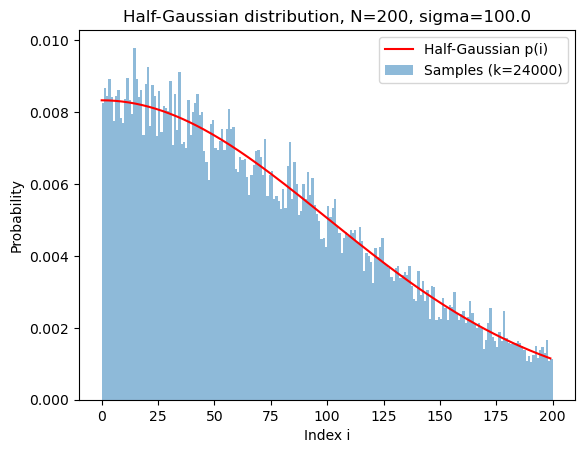

In [23]:
def demo_half_gaussian_distribution():
    # Parameters
    N = 200      # Indices in [0..199]
    sigma = 100.0

    # 1) Get half-Gaussian probabilities
    probs = half_gaussian_probs(N, sigma)
    # probs = build_probs_decaying(200, 0.99)

    # 2) We can sample from them. E.g., 10,000 samples:
    num_samples = 24_000
    population = list(range(N))  # the integer indices
    samples = random.choices(population, weights=probs, k=num_samples)

    # 3) Let's plot both:
    #    (A) The theoretical distribution p(i)
    #    (B) A histogram of the samples

    fig, ax = plt.subplots()
    indices = np.arange(N)

    # (A) Plot the theoretical distribution
    ax.plot(indices, probs, label="Half-Gaussian p(i)", color="red")

    # (B) Histogram of the samples (normalized)
    # We'll use 'density=True' so that the histogram integrates to 1
    ax.hist(samples, bins=N, range=(0, N), density=True, alpha=0.5,
            label=f"Samples (k={num_samples})")

    ax.set_title(f"Half-Gaussian distribution, N={N}, sigma={sigma}")
    ax.set_xlabel("Index i")
    ax.set_ylabel("Probability")
    ax.legend()
    plt.show()

# Run the demo:
demo_half_gaussian_distribution()

In [27]:
mine = None
for d in names: 
    dfme = get_df(exp_root,d)
    if dfme is None:
        continue
    dfme = dfme.assign(dir=d)
    cur_df_noisy = dfme[dfme["name"]=="noisy"].reset_index(drop=True)
    cur_df_noisy.loc[0,"dir"] = d
    if df_noisy is None:
        df_noisy = cur_df_noisy
    else:
        df_noisy = pd.concat([df_noisy, cur_df_noisy])
    dfme = dfme[dfme["name"] != "noisy"]
    
    dfme = dfme[dfme["stoi"]>0.5]

    for noisetype in NOISES :
        for c_snr in snrs:
            c_snr=str(c_snr)
            dfme_cur = dfme[dfme["snr"]==c_snr]
            cur_mine = dfme_cur[dfme_cur["noise_type"]==noisetype]
            cur_mine = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]
            if mine is None:
                mine = cur_mine
            else:
                mine = pd.concat([mine, cur_mine])
mine=mine.reset_index(drop=True)

In [21]:
def wavenet_receptive_field(kernel_size: int, dilations: list[int]) -> int:
    """
    Computes the sequential receptive field for a stack of causal conv blocks.

    Receptive Field = 1 + sum( (kernel_size - 1) * d_i ) over all blocks i.
    """
    rf = 1  # Start from 1 for the "current" sample
    k_minus_1 = kernel_size - 1
    
    for d in dilations:
        rf += k_minus_1 * d
    
    return rf

# Example usage:
# dilation_pattern = [1, 2, 4, 8, 8, 8, 16, 16]
dilation_pattern = [1, 1, 1, 1,1, 1, 1, 1]
# dilation_pattern = [1, 2, 4,8, 16, 4, 8, 16,32,64]
# dilation_pattern = [1, 2, 4,8, 2, 4, 8, 2, 4, 8, 2, 4, 8, 2, 4, 8, 2, 4, 8,2, 4, 8,2, 4, 8, 4, 8, 16, 32]
rf_value = wavenet_receptive_field(kernel_size=2, dilations=dilation_pattern)
print("Receptive field =", rf_value)  # 241

Receptive field = 9


In [28]:
mine

,dir,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
0,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
1,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
2,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
3,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
4,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
5,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
6,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
7,30X8,s0.07,0.522199,0.556660,1.098023,1.027847,1.955531,2.983263,2.485383,-1.011123,3.165108,3.165108,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
8,30X8,s0.07,0.522199,0.556660,1.098023,1.027847,1.955531,2.983263,2.485383,-1.011123,3.165108,3.165108,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
9,30X8,s0.07,0.522199,0.556660,1.098023,1.027847,1.955531,2.983263,2.485383,-1.011123,3.165108,3.165108,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5


In [17]:

snrs

['-5', '0', '5', '10', '15', '25']

In [25]:
exp_root = "/data/ephraim/datasets/known_noise/undiff_exps/exp_n_find_params/"
storm_enhanced_path = str( Path(exp_root)/"storm/enhanced/")
storm_clean_wav = str(Path(exp_root)/"storm"/"clean_wav")

cols =["dir","name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
mine = None
df_noisy = None


names = []
for d in os.listdir(exp_root):
    if not d in ['5f_snrs.pickle', 'storm', 'analysis','noises','noisy_wav','clean_wav',"cleans"]:
        names.append(d)

NOISES =[]
noises_root = Path(exp_root)/"noises"
for n in os.listdir(noises_root):
    n = n.split("fileid_")[1].split(".wav")[0]
    
    if "X" in n:
        n = n.split("X")[0]
    NOISES.append(n)
snrs = []
for d in os.listdir(exp_root):
    if not d in ['5f_snrs.pickle', 'storm', 'analysis','noises','noisy_wav','clean_wav',"cleans"]:
        enh_dir = Path(exp_root)/d/"enhanced_60"
        snr_dir=os.listdir(enh_dir)
        for s in snr_dir:
            c_snr = s.split("snr")[1]
            if c_snr not in snrs:
                snrs.append(c_snr)

In [ ]:



mine, df_noisy = create_mine_df(exp_root,df_noisy,mine,noises=NOISES,cols=cols,names=names,snrs=snrs)

analysis_root = os.path.join(exp_root, "analysis")
if not os.path.exists(analysis_root):
    os.mkdir(analysis_root)

SGMSE = "sgmseWSJ0"
STORM = "sgmseTIMIT"
storm_results_path = os.path.join(storm_enhanced_path,"sgmse_TIMITChime3/measures_storm.pickle")
sgmse_results_path = os.path.join(storm_enhanced_path,"sgmse_WSJ0Chime3/measures_storm.pickle")
df_storm = get_df_storm(storm_results_path)
df_sg = get_df_storm(sgmse_results_path)
write_results(mine,"ours",analysis_root=analysis_root, noises=NOISES)
write_results(df_sg,SGMSE,analysis_root=analysis_root, noises=NOISES)
write_results(df_storm,STORM,analysis_root=analysis_root, noises=NOISES)

df_storm = drop_rows_without_comparison(df_storm, mine)
df_sg= drop_rows_without_comparison(df_sg, mine)


minestats = get_stats_df(mine, "ours")
df_storm_stats = get_stats_df(df_storm, STORM)
df_sg_stats = get_stats_df(df_sg, SGMSE)
statsdf = pd.concat([minestats,df_sg_stats,df_storm_stats])
statsdf_path = os.path.join(analysis_root,"all_stats.xlsx")
# statsdf.to_excel(statsdf_path)


for dir__ in names:
    dirminestats = get_stats_df(mine, "ours", dir__)
    dir_storm_stats =  get_stats_df(df_storm[cols], STORM, dir__)
    dir_sg_stats =  get_stats_df(df_sg[cols], SGMSE, dir__)
    dirstatsdf = pd.concat([dirminestats,dir_storm_stats,dir_sg_stats])
    dir_statsdf_path = os.path.join(analysis_root,f"{dir__}_stats.xlsx")
    # dirstatsdf.to_excel(dir_statsdf_path) 


for noisetype in NOISES:
    minestats = get_stats_df(mine, "ours", noise_type=noisetype)
    df_storm_stats = get_stats_df(df_storm[cols], STORM, noise_type=noisetype)
    df_sg_stats = get_stats_df(df_sg[cols], SGMSE, noise_type=noisetype)
    statsdf = pd.concat([minestats,df_sg_stats,df_storm_stats])
    noise_statsdf_path = os.path.join(analysis_root,f"stats_{noisetype}.xlsx")
    # statsdf.to_excel(noise_statsdf_path)
    
for c_snr in snrs:
    c_snr = str(c_snr)
    minestats = get_stats_df(mine, "ours", snr_=c_snr)
    df_storm_stats = get_stats_df(df_storm[cols], STORM, snr_=c_snr)
    df_sg_stats = get_stats_df(df_sg[cols], SGMSE, snr_=c_snr)
    statsdf = pd.concat([minestats,df_sg_stats,df_storm_stats])
    snr_statsdf_path = os.path.join(analysis_root,f"stats_snr{c_snr}.xlsx")
    # statsdf.to_excel(snr_statsdf_path)

wavs_analysis_path = Path(exp_root)/"analysis"/"wavs"
if not os.path.exists(wavs_analysis_path):
    os.mkdir(wavs_analysis_path)


# copy_wavs(mine, wavs_analysis_path, "ours")
# copy_wavs(df_sg, wavs_analysis_path, SGMSE)
# copy_wavs(df_storm, wavs_analysis_path, STORM)
# copy_wavs(df_noisy, wavs_analysis_path, "noisy")

wavs = glob(str(Path(storm_clean_wav)) + "/*.wav")
for wavpath in wavs:
    c = Path(wavpath).name.split("_")[0]
    if "snr" in wavpath:
        snr = wavpath.split("snr")[1].split("_")[0]
        noisetype = Path(wavpath).name.split("noise")[1].split("_")[0]
        name = f"{c}_{noisetype}_snr{snr}_clean.wav"
        dst = wavs_analysis_path/f"{name}"
        # shutil.copyfile(wavpath, dst)

df = mine    
for i in df.index.values:
    snr = df["snr"][i]
    noisetype = df["noise_type"][i]
    dir_ = df["dir"][i]
    s = float(df["name"][i].replace("s",""))
    wavpath = df["filename"][i]
    noisy_path = Path(exp_root) / dir_ / "noisy_wav" / Path(wavpath).name

    speech, sr = torchaudio.load(noisy_path)
    vaded_signal = calc_vad(noisy_path)[0:speech.shape[1],:]
    vaded_signal_torch = (speech[0][vaded_signal.T[0]>0])
    vaded_signal_torch = torch.unsqueeze(vaded_signal_torch, dim=0)
    clean_power = float( 1 / vaded_signal_torch.shape[1] * torch.sum(vaded_signal_torch**2))
    simple_power =  float(1 / speech.shape[1] * torch.sum(speech**2))
    vaded_rate = (vaded_signal_torch.shape[1]/speech.shape[1])
    
    variance = float( torch.var(speech, unbiased=True))
    df.at[i, "clean_power"] = clean_power
    df.at[i, "simple_power"] = simple_power
    df.at[i, "vaded_rate"] = vaded_rate
    df.at[i, "variance"] = variance
write_results(mine,"ours_params",analysis_root=analysis_root, noises=NOISES)

write
write
write


/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: inva

write


In [16]:
mine[cols]

,dir,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
0,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
1,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
2,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
3,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
4,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
5,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
6,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
7,30X8,s0.07,0.522199,0.556660,1.098023,1.027847,1.955531,2.983263,2.485383,-1.011123,3.165108,3.165108,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
8,30X8,s0.07,0.522199,0.556660,1.098023,1.027847,1.955531,2.983263,2.485383,-1.011123,3.165108,3.165108,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
9,30X8,s0.07,0.522199,0.556660,1.098023,1.027847,1.955531,2.983263,2.485383,-1.011123,3.165108,3.165108,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5


In [22]:
mine.filename[0]

'/data/ephraim/datasets/known_noise/undiff_exps/exp_n_find_params/30X0.5/enhanced_60/snr-5/s0.15/noise30_book_07848_chp_0026_reader_03390_62_LoiPr_bDqow_snr-5_fileid_30.wav'

In [23]:
mine.filename[1]

'/data/ephraim/datasets/known_noise/undiff_exps/exp_n_find_params/30X0.5/enhanced_60/snr-5/s0.15/noise30_book_07848_chp_0026_reader_03390_62_LoiPr_bDqow_snr-5_fileid_30.wav'

In [68]:
s_array = []
snr_array = []
for j,n in enumerate(mine["name"]):
    n = float(n.split("s")[1])
    s_array.append(n)
    snr_ = float(mine["snr"][j])
    snr_array.append(snr_)

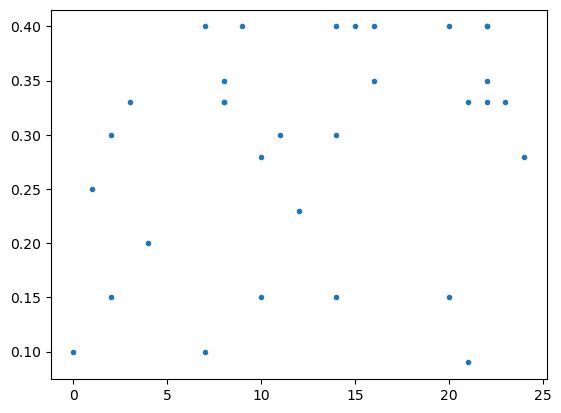

In [70]:
from matplotlib import pyplot as pyplot
plt.plot(snr_array,s_array, ".")

In [62]:
df_storm

,input_si_sdr,input_sdr,input_sir,input_sar,input_stoi,input_pesq,si_sdr,sdr,sir,sar,...,len_in_sec,sr,num_hops,OVRL_raw,SIG_raw,BAK_raw,OVRL,SIG,BAK,P808_MOS
0,19.044601,19.261939,inf,19.261939,0.984783,1.511858,19.149817,20.223051,inf,20.223051,...,1.0,16000,7,3.489866,3.866767,3.790649,3.114771,3.470394,3.811744,3.259311
11,15.845555,15.989218,inf,15.989218,0.967944,1.630079,10.564348,14.335066,inf,14.335066,...,1.0,16000,7,3.164615,3.406256,4.081295,2.898413,3.189435,3.978186,2.666927
1,11.635814,11.691771,inf,11.691771,0.000010,2.405081,9.419553,11.625541,inf,11.625541,...,1.0,16000,7,1.732680,2.067672,3.877525,1.775633,2.170534,3.863826,2.143417
2,7.037966,7.182994,inf,7.182994,0.850558,1.243633,11.537142,12.472015,inf,12.472015,...,1.0,16000,7,2.910105,3.475485,3.329777,2.719128,3.233946,3.502215,3.340996
3,-3.183176,-2.746943,inf,-2.746943,0.918516,1.049655,8.489678,10.967233,inf,10.967233,...,1.0,16000,7,3.272453,3.674097,3.939190,2.971733,3.357179,3.899588,3.212984
4,18.083784,18.231626,inf,18.231626,0.996507,1.920491,20.019300,22.028698,inf,22.028698,...,1.0,16000,7,3.814709,4.070766,4.349226,3.316569,3.583472,4.111916,3.203244
5,2.103903,2.286643,inf,2.286643,0.835145,1.094843,7.568219,10.530264,inf,10.530264,...,1.0,16000,7,2.347610,2.693429,3.510731,2.291793,2.684303,3.630416,2.557229
6,15.701641,15.767507,inf,15.767507,0.946110,1.397057,1.520924,6.051431,inf,6.051431,...,1.0,16000,7,2.664767,2.918439,3.952337,2.538006,2.852969,3.907083,3.415136
7,49.453979,49.558045,inf,49.558045,0.999989,4.604765,20.729753,22.245195,inf,22.245195,...,1.0,16000,7,3.188835,3.848099,3.405895,2.915017,3.459698,3.557193,3.300251
8,10.365370,10.429481,inf,10.429481,0.982477,1.459366,16.651371,17.326964,inf,17.326964,...,1.0,16000,7,2.712461,3.493174,2.948493,2.573854,3.245191,3.203859,2.993330


In [59]:
statsdf

,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,alg
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ours
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ours
mean,0.995513,1.0,3.970256,4.643888,2.577860,3.355454,3.131377,27.118950,28.821500,28.821500,inf,sgmseWSJ0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sgmseWSJ0
mean,0.998486,1.0,4.100904,4.643888,2.575442,3.346675,3.138208,26.510944,27.288822,27.288822,inf,sgmseTIMIT
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sgmseTIMIT


In [60]:
minestats = get_stats_df(mine, "ours")
df_storm_stats = get_stats_df(df_storm, STORM)
df_sg_stats = get_stats_df(df_sg, SGMSE)
statsdf = pd.concat([minestats,df_sg_stats,df_storm_stats])

/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [61]:
statsdf

,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,...,input_sdr,input_sir,input_sar,len_in_sec,sr,num_hops,OVRL_raw,SIG_raw,BAK_raw,P808_MOS
mean,0.902843,0.932955,1.787736,2.166166,2.417048,2.955266,3.189094,12.433356,13.301288,13.301288,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.087789,0.087645,0.538746,1.160395,0.494887,0.577697,0.654102,7.038084,7.046334,7.046334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.926095,0.891024,2.540925,2.213294,2.655861,3.202192,3.481146,16.711723,17.663817,17.663817,...,24.680217,inf,24.680217,1.0,16000.0,7.0,2.843768,3.446596,3.375251,3.044913
std,0.181764,0.203897,0.988605,1.200482,0.355640,0.276429,0.531631,7.749667,7.650861,7.650861,...,47.901067,NaN,47.901067,0.0,0.0,0.0,0.479244,0.403448,0.650338,0.337169
mean,0.921770,0.891024,2.285547,2.213294,2.622242,3.156059,3.501604,15.440343,16.913946,16.913946,...,24.680217,inf,24.680217,1.0,16000.0,7.0,2.798898,3.380492,3.394395,3.045210
std,0.177343,0.203897,0.948069,1.200482,0.365645,0.317326,0.476935,6.741400,6.159339,6.159339,...,47.901067,NaN,47.901067,0.0,0.0,0.0,0.490236,0.451182,0.608629,0.363423
